# Predizione tutte le waves

In [19]:
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from aidam.math_utils import moving_function_rev1
#from aidam.aicharts import get_subplot_cells_sequence, confplot_ax,auto_grid_shape
#from aidam.faga.curve_fit import FagaCurveFit
from scipy.optimize import curve_fit
from datetime import datetime, timedelta
from aidam.miscellanea_utils import find_matlabstyle

from covid_lib import read_covid_data, find_day_index

## Lettura dati

In [20]:
trend,regioni,giorni,giorno_settimana,popolazione,day_counter=read_covid_data('stored_data.pkl')

Giorni osservati: 431
Primo giorno: 2020-02-24T18:00:00
Ultimo giorno: 2021-04-29T17:00:00


## Estrapolazione second wave

Inizio nominale second wave: 2020-07-23T17:00:00
Valore nuovi_positivi a inizio second wave: 306.000000


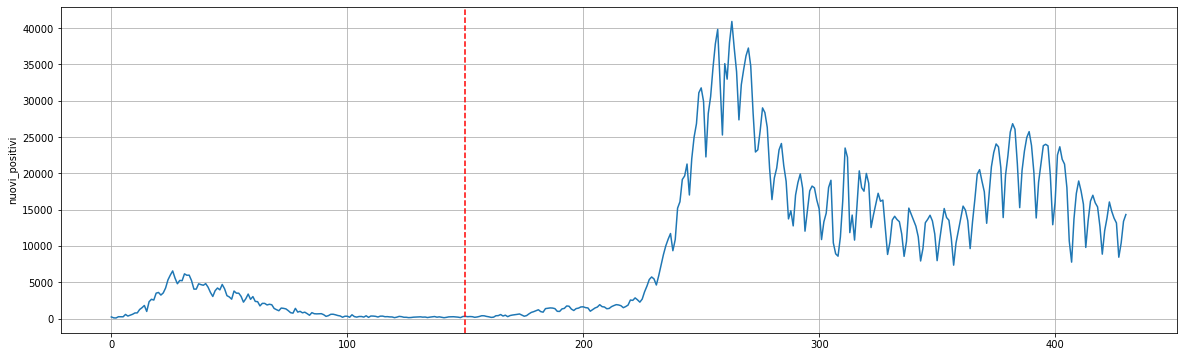

In [21]:
indicatore='nuovi_positivi'
regione='Italia'

# giorno di inizio second wave
if indicatore=='terapia_intensiva':
    sw_start=150
if indicatore=='deceduti_giornalieri':
    sw_start=150
if indicatore=='nuovi_positivi':
    sw_start=150

    
print('Inizio nominale second wave: %s'%giorni[sw_start])



fig,ax=plt.subplots(1,figsize=(20,6))
ax.plot(day_counter,trend[indicatore][regione])
ax.grid()
ax.set_ylabel(indicatore)
ax.axvline(sw_start,c='r',ls='--')


Y=trend[indicatore][regione][sw_start:]


print('Valore %s a inizio second wave: %f'%(indicatore,trend[indicatore][regione][sw_start]))

## Multi-gaussiane

In [22]:
def generic_gaussian(t,a,b,c):
    # a: altezza picco
    # b: giorno centrale
    # c: deviazione standard
    return a*np.exp(-((t-b)**2)/(2*c**2))

def multi_gaussian_creator(t,num_gaussiane,pars):
    temp=0
    for i in range(num_gaussiane):
        temp+=generic_gaussian(t,*pars[i*3:i*3+3])
    return temp

In [23]:
num_gaussians=3

my_multi_gaussian=lambda t,*pars: multi_gaussian_creator(t,num_gaussians,pars)
#start_point=[1,1,1,1,1,1]

# versione automatica
minimi=num_gaussians*[0,0,0]
massimi=num_gaussians*[1.33*np.max(Y),np.round(len(Y)*1.5),np.round(0.5*len(Y))]
'''
# versione manuale
# data picco
minimi[7]=len(Y)-10
massimi[7]=len(Y)+20
# altezza picco
minimi[6]=0.8*np.max(Y)
massimi[6]=1.1*np.max(Y)
'''

bounds=(minimi,massimi)
start_point=(np.array(bounds[0])+np.array(bounds[1]))/2

#three_gaussians=lambda t,*pars: multi_gaussian(t,3,pars)
#start_point=[1,1,1,1,1,1,1,1,1]

'''
three_gaussians=lambda t,*pars: multi_gaussian(t,3,pars)
# bounds per 3 gaussiane su nuovi positivi
bounds=([1000,10,0,20000,220,0,10000,300,0],[10000,100,100,50000,300,100,50000,500,100])
start_point=(np.array(bounds[0])+np.array(bounds[1]))/2
'''

'\nthree_gaussians=lambda t,*pars: multi_gaussian(t,3,pars)\n# bounds per 3 gaussiane su nuovi positivi\nbounds=([1000,10,0,20000,220,0,10000,300,0],[10000,100,100,50000,300,100,50000,500,100])\nstart_point=(np.array(bounds[0])+np.array(bounds[1]))/2\n'

In [24]:
print(bounds)
print(start_point)

([0, 0, 0, 0, 0, 0, 0, 0, 0], [54399.66, 422.0, 140.0, 54399.66, 422.0, 140.0, 54399.66, 422.0, 140.0])
[27199.83   211.      70.   27199.83   211.      70.   27199.83   211.
    70.  ]


In [25]:
modello_usato=my_multi_gaussian
#solution,pcov=curve_fit(modello_usato,np.arange(len(Y)),Y,p0=start_point)

# questo per limitare i giorni per il tuning
no_last_days=7

#solution,pcov=curve_fit(modello_usato,np.arange(len(Y)),Y,bounds=bounds,p0=start_point)
if no_last_days>0:
    solution,pcov=curve_fit(modello_usato,np.arange(len(Y)-no_last_days),Y[:-no_last_days],bounds=bounds,p0=start_point)
else:
    solution,pcov=curve_fit(modello_usato,np.arange(len(Y)),Y,bounds=bounds,p0=start_point)

solution

array([2.04189814e+04, 2.42800933e+02, 2.46351613e+01, 1.54694359e+04,
       1.52710322e+02, 4.11946053e+01, 2.66402544e+04, 1.09613263e+02,
       1.37238354e+01])

## Simulazione

In [26]:
simulation_days=np.arange(len(Y)+90)
y_pred=np.array(list(map(lambda x:modello_usato(x,*solution),simulation_days)))

Preparazione date

- creo il giorno 0 nel formato *datetime* per poi creare i nuovi plot su questa base
- creo una lista di giorni (in formato di stringhe) partendo dal giorno0

In [27]:
giorno0=datetime.strptime(giorni[sw_start][0:10], "%Y-%m-%d")
str_giorni=[]
for d in range(500):
    str_giorni.append((giorno0+timedelta(d)).strftime("%Y-%m-%d"))
str_giorni=np.array(str_giorni)

oggi=datetime.strftime(datetime.now(), "%Y-%m-%d")
indice_oggi=find_matlabstyle(str_giorni,lambda x:x==oggi)[0]

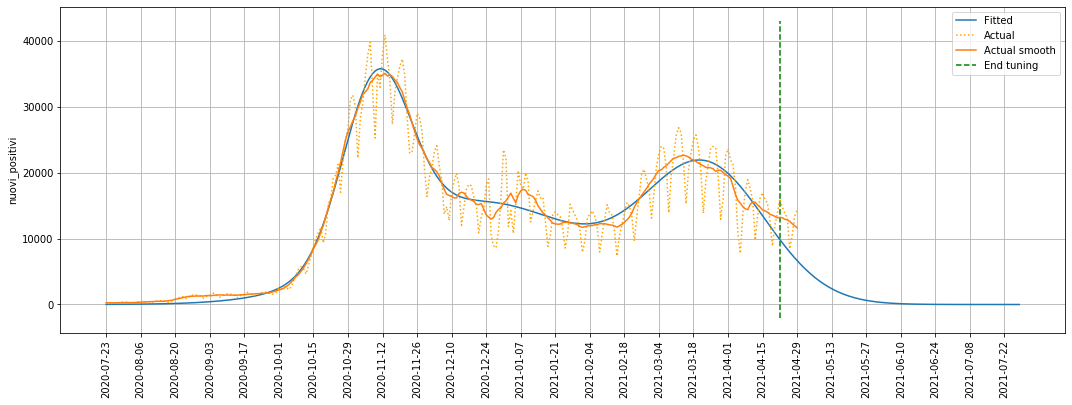

In [28]:
fig,ax=plt.subplots(1,figsize=(18,6))
ax.plot(simulation_days,y_pred,label='Fitted',linestyle='-')
ax.plot(range(len(Y)),Y,label='Actual',linestyle=':',color='orange')
ax.plot(range(len(Y)),moving_function_rev1(Y,np.mean,3,3),label='Actual smooth')
ax.vlines(len(Y)-no_last_days-1,ax.get_ylim()[0],ax.get_ylim()[1],linestyles='--',color='g',label='End tuning')
ax.grid()
ax.set_xticks(list(range(0,len(simulation_days),14)))
ax.set_xticklabels(str_giorni[list(range(0,len(simulation_days),14))],rotation=90)

ax.set_ylabel(indicatore)
ax.legend()


In [29]:
ax.get_ylim()

(-4294.657799150065, 45196.70503973824)

In [30]:
for d in simulation_days:
    if d<len(Y):
        print('[%3d]  %s  Act: %6d Pred: %.1f'%(d,str_giorni[d],Y[d],y_pred[d]))
    else:
        print('[%3d]  %s  Act: %6d Pred: %.1f'%(d,str_giorni[d],0,y_pred[d]))   

[  0]  2020-07-23  Act:    306 Pred: 16.0
[  1]  2020-07-24  Act:    252 Pred: 17.6
[  2]  2020-07-25  Act:    275 Pred: 19.2
[  3]  2020-07-26  Act:    255 Pred: 21.0
[  4]  2020-07-27  Act:    170 Pred: 22.9
[  5]  2020-07-28  Act:    212 Pred: 25.0
[  6]  2020-07-29  Act:    289 Pred: 27.2
[  7]  2020-07-30  Act:    386 Pred: 29.7
[  8]  2020-07-31  Act:    379 Pred: 32.3
[  9]  2020-08-01  Act:    295 Pred: 35.2
[ 10]  2020-08-02  Act:    239 Pred: 38.3
[ 11]  2020-08-03  Act:    159 Pred: 41.7
[ 12]  2020-08-04  Act:    190 Pred: 45.3
[ 13]  2020-08-05  Act:    384 Pred: 49.2
[ 14]  2020-08-06  Act:    402 Pred: 53.4
[ 15]  2020-08-07  Act:    552 Pred: 57.9
[ 16]  2020-08-08  Act:    347 Pred: 62.8
[ 17]  2020-08-09  Act:    463 Pred: 68.0
[ 18]  2020-08-10  Act:    259 Pred: 73.7
[ 19]  2020-08-11  Act:    412 Pred: 79.8
[ 20]  2020-08-12  Act:    481 Pred: 86.3
[ 21]  2020-08-13  Act:    523 Pred: 93.3
[ 22]  2020-08-14  Act:    574 Pred: 100.8
[ 23]  2020-08-15  Act:    629 Pr